In [1]:
import pyspark
import pandas as pd
import pyflux as pf
from datetime import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline
from pandas_summary import DataFrameSummary
import warnings
warnings.filterwarnings('ignore')

import plotly.plotly as py  
import plotly.tools as tls   
import plotly.graph_objs as go

# Stream IDs required by plotly for all 7 plots
stream_ids = ['m412v4fff5', '91kgio2avn', 't4bpa4tgd1', 'lxszlqpjwd', 'ih8fbjs30q', '3rf8q3syzi', '1o71ca2j1y', '8xj9sb2zf8', \
             'wc80xqhnn2', '13sdj466eu', 'mvj0hwifry', 'inapwvh2lz', 'pvaysuac29', '91knzbszgb', 'omc4ttf93b', 'qlvuq7ykuu', \
             'f3mr9kzm7p', 'ghz0wn33g9', 'xnrv6fzn8f', 'ml89rlr5x6', '7cbkpl5kug', '1ly2brvu8j', '3wqeswjnyk', 'awfpi56n8n', \
             'mmkje4rst1', 'pzt0nk3jsz', '806xvxs4u9', 'up9kduuf5u']

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 1000)

In [2]:
#set file path for IDIRECT_DATA/Stats table
verizon_stats_data = '/home/andy/Desktop/data/verizon_IDIRECT_DATA.csv'

In [3]:
#Obtain stats dataset
stats_df = spark.read.csv(verizon_stats_data, header='true', inferSchema='true', sep=',')

In [4]:
#Convert stats dataframe into parquet -- cuts filesize down from 3.4 GB to 0.5GB
#stats_df.write.parquet('/home/andy/Desktop/data/verizon_IDIRECT_DATA.parquet')

#Read from parquet
stats_df = spark.read.parquet('/home/andy/Desktop/data/verizon_IDIRECT_DATA.parquet')

In [5]:
#Import stats_df into cache - improve query response. 
#stats_df.cache()


In [6]:
#Create View from stats_df dataframe so we can use SQL to query. 
stats_df.createOrReplaceTempView("statsView")

In [7]:
# createOrReplaceTempView creates (or replaces if already exists) a lazily evaluated 'view'
# that you can use as a  Hive/SQL table in SparkSQL. 
# NOTE: It does not persist to memory unless you cache the dataset that underpins the view. 
#spark.table("statsView").cache

In [8]:
#The data is cached fully only after the .count call
# Gives the number of rows in dataset
#spark.table("statsView").count()

In [9]:
# Find the top 10 terminal occurances within the dataset.                                                                                                                                          
id_occurs_most_df = spark.sql("""
SELECT ID, count(ID) as counted 
FROM statsview 
GROUP BY ID 
ORDER BY counted DESC""").show(10)                                    

+----+-------+
|  ID|counted|
+----+-------+
|2489|  63695|
|2535|  63373|
|2682|  63296|
|2753|  63295|
|2668|  63292|
|2702|  63287|
|2704|  63281|
|2697|  63272|
|2618|  63240|
|2506|  63217|
+----+-------+
only showing top 10 rows



In [10]:
# Shows that there are terminals in two regions with same ID in IDIRECT DATA table. One is active the other not. 
# I have filtered away data from the inactive terminal. 

downstream_snr_df = spark.sql("SELECT ID, EPOCH, DOWNSTREAM_SNR, RX_TRAFFIC FROM statsView WHERE ID=2489")
downstream_snr_df.show(10)

+----+----------+--------------+----------+
|  ID|     EPOCH|DOWNSTREAM_SNR|RX_TRAFFIC|
+----+----------+--------------+----------+
|2489|1349144700|          null|         0|
|2489|1349145000|           944|      1267|
|2489|1349145000|          null|         0|
|2489|1349145300|           942|      1265|
|2489|1349145300|          null|         0|
|2489|1349145600|           936|      1254|
|2489|1349145600|          null|         0|
|2489|1349145900|           939|      1367|
|2489|1349145900|          null|         0|
|2489|1349146200|           935|      1349|
+----+----------+--------------+----------+
only showing top 10 rows



In [11]:
# Create dataframe containing downstream_snr column only.
# Create new column in same dataframe with converted DOWNSTREAM_SNR obtained by applying 
# DISPLAY_OFFSET (addition) from the table SERIES_INFO and then DISPLAY_DIVISOR from same table (division). 
downstream_snr_df = spark.sql("""
SELECT ID, EPOCH, DOWNSTREAM_SNR 
FROM statsView 
WHERE ID=2489 """)

# convert DOWNSTREAM_SNR using values from SERIES_INFO table. 
conv_dwnstream_df = downstream_snr_df.withColumn('CONVERTED_DOWNSTREAM_SNR', downstream_snr_df['DOWNSTREAM_SNR'] /100)
# Drop column DOWNSTREAM_SNR 
conv_dwnstream_df = conv_dwnstream_df.drop('DOWNSTREAM_SNR')
# drop any nulls from rows
conv_dwnstream_df = conv_dwnstream_df.dropna(how='any')



#create dataframe containing upstream_snr column only
upstream_snr_df = spark.sql("""
SELECT ID, EPOCH, UPSTREAM_SNR 
FROM statsView 
WHERE ID=2489""")

conv_upstream_df = upstream_snr_df.withColumn('CONVERTED_UPSTREAM_SNR', upstream_snr_df['UPSTREAM_SNR'] /100)
conv_upstream_df = conv_upstream_df.drop('UPSTREAM_SNR')
conv_upstream_df = conv_upstream_df.dropna(how='any')


# rx_traffic and tx_traffic contain 0's instead of nulls for empty row. So remove/filter for 0's 
# from rows for both fields
rx_traffic_df = spark.sql("""
SELECT ID, EPOCH, RX_TRAFFIC 
FROM statsView 
WHERE ID=2489 
AND RX_TRAFFIC <> 0""")

conv_rx_traffic_df = rx_traffic_df.withColumn('CONVERTED_RX_TRAFFIC', rx_traffic_df['RX_TRAFFIC'] /16)
conv_rx_traffic_df = conv_rx_traffic_df.drop('RX_TRAFFIC')
conv_rx_traffic_df = conv_rx_traffic_df.dropna(how='any')

tx_traffic_df = spark.sql("""
SELECT ID, EPOCH, TX_TRAFFIC 
FROM statsView 
WHERE ID=2489 
AND TX_TRAFFIC <> 0""")

conv_tx_traffic_df = tx_traffic_df.withColumn('CONVERTED_TX_TRAFFIC', tx_traffic_df['TX_TRAFFIC'] /16)
conv_tx_traffic_df = conv_tx_traffic_df.drop('TX_TRAFFIC')
conv_tx_traffic_df = conv_tx_traffic_df.dropna(how='any')

rx_power_df = spark.sql("""
SELECT ID, EPOCH, RX_POWER 
FROM statsView 
WHERE ID=2489""")

conv_rx_power_df = rx_power_df.withColumn('CONVERTED_RX_POWER', rx_power_df['RX_POWER'] /-10)
conv_rx_power_df = conv_rx_power_df.drop('RX_POWER')
conv_rx_power_df = conv_rx_power_df.dropna(how='any')

tx_power_df = spark.sql("""
SELECT ID, EPOCH, TX_POWER 
FROM statsView 
WHERE ID=2489""")

conv_tx_power_df = tx_power_df.withColumn('CONVERTED_TX_POWER', tx_power_df['TX_POWER'] /-10)
conv_tx_power_df = conv_tx_power_df.drop('TX_POWER')
conv_tx_power_df = conv_tx_power_df.dropna(how='any')

# There a quite a few nulls in the Latency column. 
latency_df = spark.sql("""
SELECT ID, EPOCH, LATENCY 
FROM statsView 
WHERE ID=2489""")

conv_latency_df = latency_df.withColumn('CONVERTED_LATENCY', latency_df['LATENCY'])
conv_latency_df = conv_latency_df.drop('LATENCY')
conv_latency_df = conv_latency_df.dropna(how='any')

In [12]:
# Convert conv dataframes to pandas dataframes
conv_dwnstream_pdf = conv_dwnstream_df.toPandas()
conv_upstream_pdf = conv_upstream_df.toPandas()
conv_rx_traffic_pdf = conv_rx_traffic_df.toPandas()
conv_tx_traffic_pdf = conv_tx_traffic_df.toPandas()
conv_rx_power_pdf = conv_rx_power_df.toPandas()
conv_tx_power_pdf = conv_tx_power_df.toPandas()
conv_latency_pdf = conv_latency_df.toPandas()

In [13]:
#######################################  pandas code  ##############################################

In [14]:
# re-index pandas dataframe as current index is EPOCH_DATE
new_conv_dwnstream_pdf = conv_dwnstream_pdf.reset_index()
new_conv_dwnstream_pdf.drop('index', axis=1, inplace=True)
new_conv_upstream_pdf = conv_upstream_pdf.reset_index()
new_conv_upstream_pdf.drop('index', axis=1, inplace=True)
new_conv_rx_traffic_pdf = conv_rx_traffic_pdf.reset_index()
new_conv_rx_traffic_pdf.drop('index', axis=1, inplace=True)
new_conv_tx_traffic_pdf = conv_tx_traffic_pdf.reset_index()
new_conv_tx_traffic_pdf.drop('index', axis=1, inplace=True)
new_conv_rx_power_pdf = conv_rx_power_pdf.reset_index()
new_conv_rx_power_pdf.drop('index', axis=1, inplace=True)
new_conv_tx_power_pdf = conv_tx_power_pdf.reset_index()
new_conv_tx_power_pdf.drop('index', axis=1, inplace=True)
new_conv_latency_pdf = conv_latency_pdf.reset_index()
new_conv_latency_pdf.drop('index', axis=1, inplace=True)

In [15]:
# Write out pandas dataframes to disk 
new_conv_dwnstream_pdf.to_csv('/home/andy/Desktop/data/cleaned_dataframes/downstream_snr_dataframe_cleaned.csv' \
                              ,header=True)
new_conv_upstream_pdf.to_csv('/home/andy/Desktop/data/cleaned_dataframes/upstream_snr_dataframe_cleaned.csv', \
                             header=True)
new_conv_rx_traffic_pdf.to_csv('/home/andy/Desktop/data/cleaned_dataframes/rx_traffic_dataframe_cleaned.csv', \
                               header=True)
new_conv_tx_traffic_pdf.to_csv('/home/andy/Desktop/data/cleaned_dataframes/tx_traffic_dataframe_cleaned.csv', \
                               header=True)
new_conv_rx_power_pdf.to_csv('/home/andy/Desktop/data/cleaned_dataframes/rx_power_dataframe_cleaned.csv', \
                             header=True)
new_conv_tx_power_pdf.to_csv('/home/andy/Desktop/data/cleaned_dataframes/tx_power_dataframe_cleaned.csv', \
                             header=True)
new_conv_latency_pdf.to_csv('/home/andy/Desktop/data/cleaned_dataframes/latency_dataframe_cleaned.csv', \
                            header=True)

In [16]:
# More indepth stats on each column. 
dfs_conv_dwnstream_pdf = DataFrameSummary(new_conv_dwnstream_pdf)
dfs_conv_upstream_pdf = DataFrameSummary(new_conv_upstream_pdf)
dfs_rx_traffic_pdf = DataFrameSummary(new_conv_rx_traffic_pdf)
dfs_tx_traffic_pdf = DataFrameSummary(new_conv_tx_traffic_pdf)
dfs_rx_power_pdf = DataFrameSummary(new_conv_rx_power_pdf)
dfs_tx_power_pdf = DataFrameSummary(new_conv_tx_power_pdf)
dfs_latency_pdf = DataFrameSummary(new_conv_latency_pdf)

In [17]:
dfs_conv_dwnstream_pdf.columns_stats

,ID,EPOCH,CONVERTED_DOWNSTREAM_SNR
counts,24149,24149,24149
uniques,1,23862,1189
missing,0,0,0
missing_perc,0%,0%,0%
types,constant,numeric,numeric


mean                         12.1087
std                          2.22366
variance                     4.94465
min                             0.11
max                            46.35
5%                              7.79
25%                             11.3
50%                            12.49
75%                             13.5
95%                            15.05
iqr                              2.2
kurtosis                     4.71034
skewness                    -1.13567
sum                           292413
mad                          1.63353
cv                          0.183641
zeros_num                          0
zeros_perc                        0%
deviating_of_mean                  1
deviating_of_mean_perc         0.00%
deviating_of_median                1
deviating_of_median_perc       0.00%
top_correlations                    
counts                         24149
uniques                         1189
missing                            0
missing_perc                      0%
t

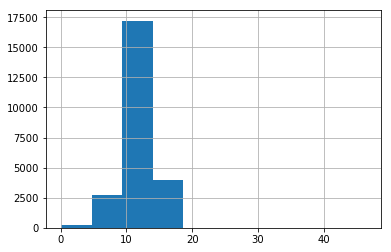

In [18]:
dfs_conv_dwnstream_pdf['CONVERTED_DOWNSTREAM_SNR']

In [19]:
dfs_conv_upstream_pdf.columns_stats

,ID,EPOCH,CONVERTED_UPSTREAM_SNR
counts,24157,24157,24157
uniques,1,23870,326
missing,0,0,0
missing_perc,0%,0%,0%
types,constant,numeric,numeric


mean                          8.70556
std                          0.685288
variance                      0.46962
min                              3.87
max                             10.54
5%                               7.61
25%                              8.15
50%                              8.71
75%                              9.33
95%                              9.69
iqr                              1.18
kurtosis                    -0.615183
skewness                     -0.21938
sum                            210300
mad                          0.591321
cv                          0.0787185
zeros_num                           0
zeros_perc                         0%
deviating_of_mean                   0
deviating_of_mean_perc             0%
deviating_of_median                 2
deviating_of_median_perc        0.01%
top_correlations                     
counts                          24157
uniques                           326
missing                             0
missing_perc

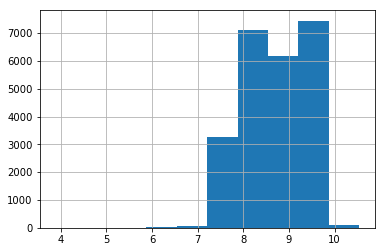

In [20]:
dfs_conv_upstream_pdf['CONVERTED_UPSTREAM_SNR']

In [21]:
dfs_rx_traffic_pdf.columns_stats

,ID,EPOCH,CONVERTED_RX_TRAFFIC
counts,24133,24133,24133
uniques,1,23846,1190
missing,0,0,0
missing_perc,0%,0%,0%
types,constant,numeric,numeric


mean                        10.0596
std                         16.7308
variance                    279.921
min                          0.0625
max                         496.812
5%                           0.9375
25%                          1.8125
50%                          4.8125
75%                            11.5
95%                         35.2125
iqr                          9.6875
kurtosis                    141.478
skewness                    8.07344
sum                          242767
mad                         9.30682
cv                          1.66318
zeros_num                         0
zeros_perc                       0%
deviating_of_mean               373
deviating_of_mean_perc        1.55%
deviating_of_median            1407
deviating_of_median_perc      5.83%
top_correlations                   
counts                        24133
uniques                        1190
missing                           0
missing_perc                     0%
types                       

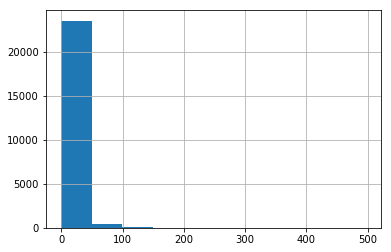

In [22]:
dfs_rx_traffic_pdf['CONVERTED_RX_TRAFFIC']

In [23]:
dfs_tx_traffic_pdf.columns_stats

,ID,EPOCH,CONVERTED_TX_TRAFFIC
counts,24070,24070,24070
uniques,1,23783,3028
missing,0,0,0
missing_perc,0%,0%,0%
types,constant,numeric,numeric


mean                        31.5369
std                         60.8895
variance                    3707.53
min                          0.0625
max                         495.688
5%                            0.625
25%                          1.4375
50%                          6.0625
75%                         33.1875
95%                         154.812
iqr                           31.75
kurtosis                    16.2339
skewness                     3.6213
sum                          759092
mad                         36.8831
cv                          1.93074
zeros_num                         0
zeros_perc                       0%
deviating_of_mean               650
deviating_of_mean_perc        2.70%
deviating_of_median            1691
deviating_of_median_perc      7.03%
top_correlations                   
counts                        24070
uniques                        3028
missing                           0
missing_perc                     0%
types                       

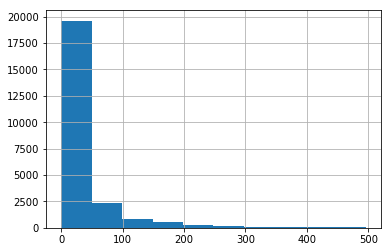

In [24]:
dfs_tx_traffic_pdf['CONVERTED_TX_TRAFFIC']

In [25]:
dfs_rx_power_pdf.columns_stats

,ID,EPOCH,CONVERTED_RX_POWER
counts,24149,24149,24149
uniques,1,23862,66
missing,0,0,0
missing_perc,0%,0%,0%
types,constant,numeric,numeric


mean                           -53.5206
std                             1.51368
variance                        2.29122
min                               -62.2
max                               -50.3
5%                                  -56
25%                               -54.7
50%                               -53.5
75%                               -52.2
95%                               -51.2
iqr                                 2.5
kurtosis                       -1.00675
skewness                       -0.11845
sum                        -1.29247e+06
mad                             1.30165
cv                           -0.0282822
zeros_num                             0
zeros_perc                           0%
deviating_of_mean                     0
deviating_of_mean_perc               0%
deviating_of_median                   0
deviating_of_median_perc             0%
top_correlations                       
counts                            24149
uniques                              66


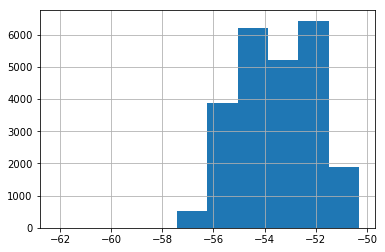

In [26]:
dfs_rx_power_pdf['CONVERTED_RX_POWER']

In [27]:
dfs_tx_power_pdf.columns_stats

,ID,EPOCH,CONVERTED_TX_POWER
counts,24149,24149,24149
uniques,1,23862,165
missing,0,0,0
missing_perc,0%,0%,0%
types,constant,numeric,numeric


mean                        -18.8707
std                          3.18932
variance                     10.1718
min                              -24
max                               -6
5%                               -23
25%                              -22
50%                              -19
75%                              -17
95%                              -13
iqr                                5
kurtosis                   -0.135314
skewness                    0.572137
sum                          -455709
mad                          2.58812
cv                         -0.169009
zeros_num                          0
zeros_perc                        0%
deviating_of_mean                 72
deviating_of_mean_perc         0.30%
deviating_of_median              309
deviating_of_median_perc       1.28%
top_correlations                    
counts                         24149
uniques                          165
missing                            0
missing_perc                      0%
t

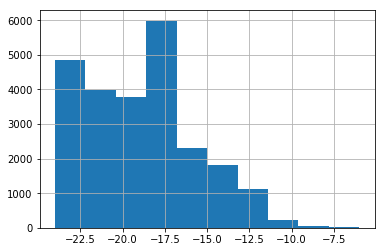

In [28]:
dfs_tx_power_pdf['CONVERTED_TX_POWER']

In [29]:
dfs_latency_pdf.columns_stats

,ID,EPOCH,CONVERTED_LATENCY
counts,16626,16626,16626
uniques,1,16339,451
missing,0,0,0
missing_perc,0%,0%,0%
types,constant,numeric,numeric


mean                         963.904
std                          116.403
variance                     13549.6
min                              581
max                             2860
5%                               608
25%                              965
50%                              983
75%                             1003
95%                             1063
iqr                               38
kurtosis                     14.9204
skewness                    -1.28498
sum                         16025872
mad                          60.0971
cv                          0.120762
zeros_num                          0
zeros_perc                        0%
deviating_of_mean                 30
deviating_of_mean_perc         0.18%
deviating_of_median              170
deviating_of_median_perc       1.02%
top_correlations                    
counts                         16626
uniques                          451
missing                            0
missing_perc                      0%
t

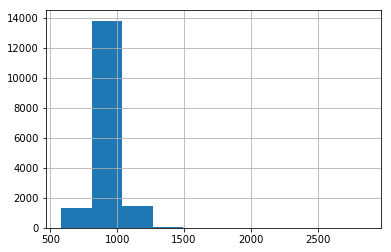

In [30]:
dfs_latency_pdf['CONVERTED_LATENCY']

In [31]:
# Convert EPOCH from unixtime into date and append to dataframe
conv_dwnstream_pdf['EPOCH_DATE'] = pd.to_datetime(conv_dwnstream_pdf['EPOCH'], unit='s')
conv_upstream_pdf['EPOCH_DATE'] = pd.to_datetime(conv_upstream_pdf['EPOCH'], unit='s')
conv_rx_traffic_pdf['EPOCH_DATE'] = pd.to_datetime(conv_rx_traffic_pdf['EPOCH'], unit='s')
conv_tx_traffic_pdf['EPOCH_DATE'] = pd.to_datetime(conv_tx_traffic_pdf['EPOCH'], unit='s')
conv_rx_power_pdf['EPOCH_DATE'] = pd.to_datetime(conv_rx_power_pdf['EPOCH'], unit='s')
conv_tx_power_pdf['EPOCH_DATE'] = pd.to_datetime(conv_tx_power_pdf['EPOCH'], unit='s')
conv_latency_pdf['EPOCH_DATE'] = pd.to_datetime(conv_latency_pdf['EPOCH'], unit='s')

In [32]:
# sort dataframes by EPOCH_DATE column ascending 
sorted_conv_dwnstream_pdf = conv_dwnstream_pdf.sort_values(by='EPOCH_DATE', axis=0, ascending=True)
sorted_conv_upstream_pdf = conv_upstream_pdf.sort_values(by='EPOCH_DATE', axis=0, ascending=True)
sorted_conv_rx_traffic_pdf = conv_rx_traffic_pdf.sort_values(by='EPOCH_DATE', axis=0, ascending=True)
sorted_conv_tx_traffic_pdf = conv_tx_traffic_pdf.sort_values(by='EPOCH_DATE', axis=0, ascending=True)
sorted_conv_rx_power_pdf = conv_rx_power_pdf.sort_values(by='EPOCH_DATE', axis=0, ascending=True)
sorted_conv_tx_power_pdf = conv_tx_power_pdf.sort_values(by='EPOCH_DATE', axis=0, ascending=True)
sorted_conv_latency_pdf = conv_latency_pdf.sort_values(by='EPOCH_DATE', axis=0, ascending=True)

In [33]:
###################### Create training and test datasets     

In [34]:
# Create testing dataset that holds 1799 datapoints (approx 3 days) of datapoints for entire dataset.
X_train_dwnstream = sorted_conv_dwnstream_pdf[['EPOCH_DATE', 'CONVERTED_DOWNSTREAM_SNR']]
size_dwnstream_array = len(X_train_dwnstream)
lower_limit_dwnstream_test = round(size_dwnstream_array * 0.9)

X_test_dwnstream = X_train_dwnstream[lower_limit_dwnstream_test:]
size_of_dwnstream_testing_set = X_test_dwnstream.shape[0]

In [35]:
# Split upstream_snr dataframe into separate Train (90%) and test(10%) datasets
X_train_upstream = sorted_conv_upstream_pdf[['EPOCH_DATE', 'CONVERTED_UPSTREAM_SNR']]
size_upstream_array = len(X_train_upstream)
lower_limit_upstream_test = round(size_upstream_array * 0.9)

X_test_upstream = X_train_upstream[lower_limit_upstream_test:]
size_of_upstream_testing_set = X_test_upstream.shape[0]

In [36]:
# Split RX_TRAFFIC dataframe into separate Train (90%) and test(10%) datasets
X_train_rx_traffic = sorted_conv_rx_traffic_pdf[['EPOCH_DATE', 'CONVERTED_RX_TRAFFIC']]
size_rx_traffic_array = len(X_train_rx_traffic)
lower_limit_rx_traffic_test = round(size_rx_traffic_array * 0.9)

X_test_rx_traffic = X_train_rx_traffic[lower_limit_rx_traffic_test:]
size_of_rx_traffic_testing_set = X_test_rx_traffic.shape[0]

In [37]:
# Split TX_TRAFFIC dataframe into separate Train (90%) and test(10%) datasets
X_train_tx_traffic = sorted_conv_tx_traffic_pdf[['EPOCH_DATE', 'CONVERTED_TX_TRAFFIC']]
size_tx_traffic_array = len(X_train_tx_traffic)
lower_limit_tx_traffic_test = round(size_tx_traffic_array * 0.9)

X_test_tx_traffic = X_train_tx_traffic[lower_limit_tx_traffic_test:]
size_of_tx_traffic_testing_set = X_test_tx_traffic.shape[0]

In [38]:
# Split RX_POWER dataframe into separate Train (90%) and test(10%) datasets
X_train_rx_power = sorted_conv_rx_power_pdf[['EPOCH_DATE', 'CONVERTED_RX_POWER']]
size_rx_power_array = len(X_train_rx_power)
lower_limit_rx_power_test = round(size_rx_power_array * 0.9)

X_test_rx_power = X_train_rx_power[lower_limit_rx_power_test:]
size_of_rx_power_testing_set = X_test_rx_power.shape[0]

In [39]:
# Split TX_POWER dataframe into separate Train (90%) and test(10%) datasets
X_train_tx_power = sorted_conv_tx_power_pdf[['EPOCH_DATE', 'CONVERTED_TX_POWER']]
size_tx_power_array = len(X_train_tx_power)
lower_limit_tx_power_array = round(size_tx_power_array * 0.9)

X_test_tx_power = X_train_tx_power[lower_limit_tx_power_array:]
size_of_tx_power_testing_set = X_test_tx_power.shape[0]

In [40]:
# Split LATENCY dataframe into separate Train (90%) and test(10%) datasets
X_train_latency = sorted_conv_latency_pdf[['EPOCH_DATE', 'CONVERTED_LATENCY']]
size_latency_array = len(X_train_latency)
lower_limit_latency_array = round(size_latency_array * 0.9)

X_test_latency = X_train_latency[lower_limit_latency_array:]
size_of_latency_testing_set = X_test_latency.shape[0]

In [41]:
####################### Start of Pyflux visualisations ############################################

In [42]:
############ DOWNSTREAM_SNR ######################################

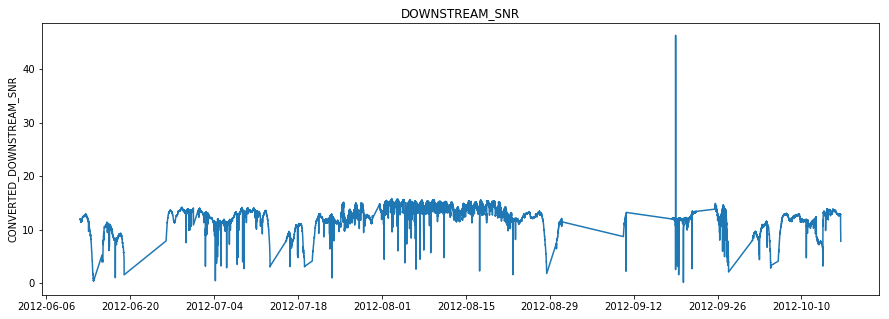

In [43]:
data_downstream = X_train_dwnstream.copy(deep=True)
data_downstream.index = data_downstream['EPOCH_DATE'].values

plt.figure(figsize=(15,5))
plt.plot(data_downstream.index, data_downstream['CONVERTED_DOWNSTREAM_SNR'])
plt.ylabel('CONVERTED_DOWNSTREAM_SNR')
plt.title('DOWNSTREAM_SNR');

In [44]:
########################## ARIMA Modelling for DOWNSTREAM_SNR ###############################

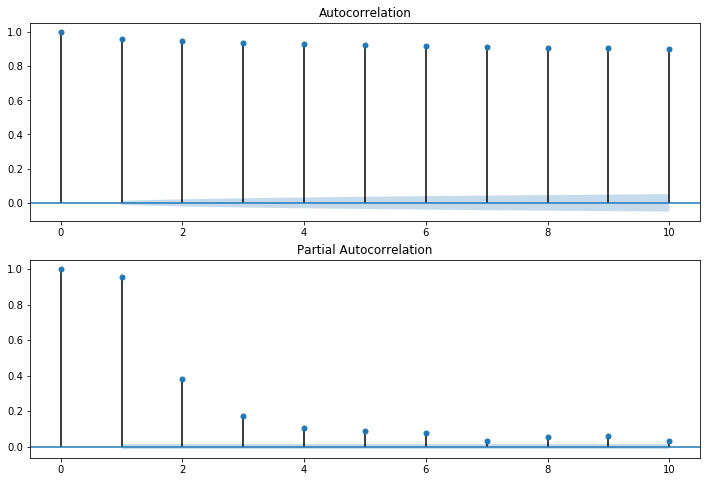

In [45]:
# Using statsmodels to obtain partial autocorrelation plot
from scipy import stats
import statsmodels.api as sm 
from statsmodels.graphics.api import qqplot 

dta = data_downstream

dta.index = data_downstream['EPOCH_DATE']

# For no differencing - Autocorrelation slope is downward suggesting current values are more correlated 
# with recent values than values much further in the past - also suggests time series is not stationary 
# - needs to be differenced.  

# Autocorrellation 

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dta['CONVERTED_DOWNSTREAM_SNR'].values.squeeze(), lags=10, ax=ax1);
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dta['CONVERTED_DOWNSTREAM_SNR'], lags=10, ax=ax2);



In [46]:
# Build the ARIMA model. Here we specify an arbitary ARIMA(2,0,0) model. 
model_downstream = pf.ARIMA(data=data_downstream, ar=2, ma=0, integ=0, target='CONVERTED_DOWNSTREAM_SNR')

In [47]:
#Estimate the latent variables using maximum likelihood point mass estimate z^MLE
downstream_latent_vars = model_downstream.fit("MLE")
downstream_latent_vars.summary()

Normal ARIMA(2,0,0)                                                                                       
======================================================= ==================================================
Dependent Variable: CONVERTED_DOWNSTREAM_SNR            Method: MLE                                       
Start Date: 2012-06-11 14:00:00                         Log Likelihood: -22133.7675                       
End Date: 2012-10-16 13:35:00                           AIC: 44275.5351                                   
Number of observations: 24147                           BIC: 44307.9027                                   
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 0.3311     0.0218     15.1923  0.0      (0.2884 | 0.3739)        
AR(1)                                

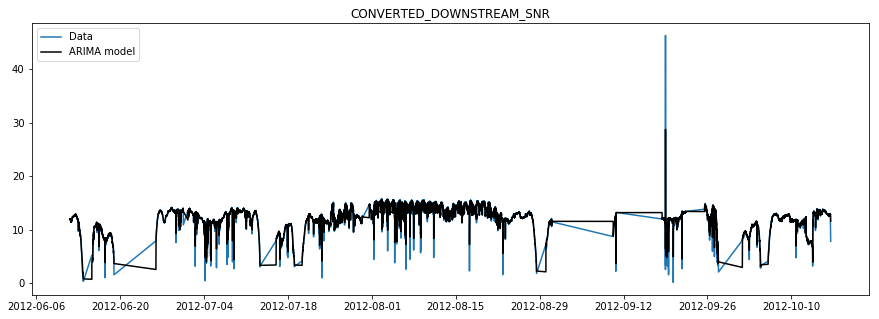

In [48]:
# plot the in-sample fit 
model_downstream.plot_fit(figsize=(15,5));

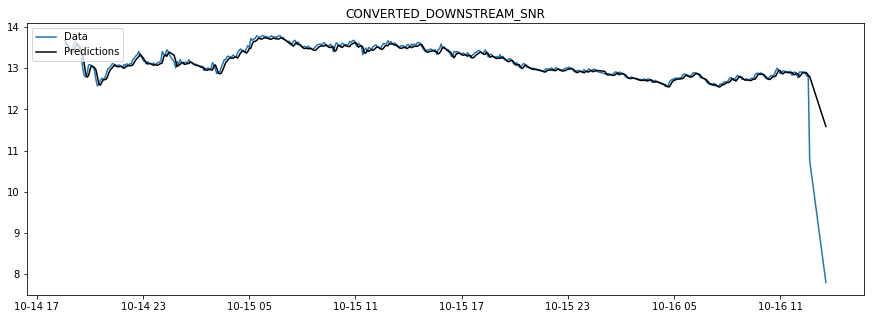

In [49]:
# get an idea of performance of model by using rolling in-sample prediction through the plot_predict_is function
model_downstream.plot_predict_is(500, figsize=(15,5));

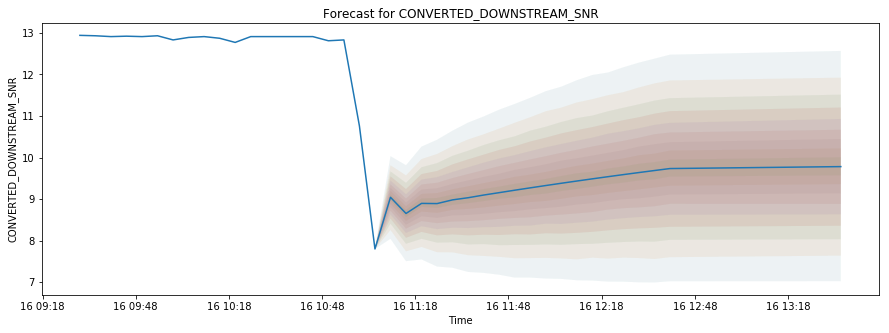

In [50]:
# We can plot h-step ahead predictions using the plot_predict function 
model_downstream.plot_predict(h=20, past_values=20, figsize=(15,5))

In [51]:
# Generate Predictions
downstream_model_predictions = model_downstream.predict(h=size_of_dwnstream_testing_set)

In [52]:
downstream_model_predictions

,CONVERTED_DOWNSTREAM_SNR
EPOCH_DATE,
2012-10-07 23:35:00,9.043563
2012-10-07 23:40:00,8.654253
2012-10-07 23:45:00,8.896667
2012-10-07 23:50:00,8.892168
2012-10-07 23:55:00,8.981707
2012-10-08 00:00:00,9.033029
2012-10-08 00:05:00,9.097482
2012-10-08 00:10:00,9.155177
2012-10-08 00:15:00,9.213864


In [53]:
# Reset index and rename columns for model_predictions 
downstream_model_predictions_reset_index = downstream_model_predictions.reset_index()
downstream_model_predictions_reset_index.columns = ['EPOCH_DATE', 'PREDICTED_CONVERTED_DOWNSTREAM_SNR']

In [54]:
# Save out X_train (real) and X_test_dwnstream (real) dataframes and also predictions to csv/disk

X_train_dwnstream[['EPOCH_DATE', 'CONVERTED_DOWNSTREAM_SNR']].to_csv('/home/andy/Desktop/data/results_from_pyflux/dwnstream_real_training_data.csv', header=True, index=False)
X_test_dwnstream[['EPOCH_DATE', 'CONVERTED_DOWNSTREAM_SNR']].to_csv('/home/andy/Desktop/data/results_from_pyflux/dwnstream_real_test_data.csv', header=True, index=False)
downstream_model_predictions_reset_index.to_csv('/home/andy/Desktop/data/results_from_pyflux/dwnstream_model_predictions_' + downstream_latent_vars.model_name + '.csv', header=True, index=False)

In [55]:
###############      Start of plotly visualisations   ###################

In [56]:
# A.Mason
# Script to produce Downstream_SNR streaming plot in plotly 
# Produced as part of mini-project work.
# Requires four streaming tokens from plotly (select four from stream_ids list below. )
# 08/08/2017

In [57]:
import plotly

In [58]:
plotly.tools.set_credentials_file(username='andym454545', api_key='HeNiO7tHTWSxKHv7ECEK')

In [59]:
predictions = pd.read_csv('/home/andy/Desktop/data/plotly_data/dwnstream_model_predictions_Normal ARIMA(10,0,4).csv')
real = pd.read_csv('/home/andy/Desktop/data/plotly_data/dwnstream_real_test_data.csv')

In [60]:
upper_pred_limit = predictions['PREDICTED_CONVERTED_DOWNSTREAM_SNR'] + 1.1

In [61]:
lower_pred_limit = predictions['PREDICTED_CONVERTED_DOWNSTREAM_SNR'] - 1.3

In [62]:
# Get stream id from stream id list 
# predictions line
stream_id_one = stream_ids[0]
# real line
stream_id_two = stream_ids[1]
# upper bound around prediction 
stream_id_three = stream_ids[2]
# lower bound around prediction
stream_id_four = stream_ids[3]

# Make instance of stream id object 
stream_1 = go.Stream(
    token=stream_id_one,  # link stream id to 'token' key
    maxpoints=100      # keep a max of 100 pts on screen
)

stream_2 = go.Stream(
    token=stream_id_two, 
    maxpoints=100)

stream_3 = go.Stream(
    token=stream_id_three,
    maxpoints = 100)

stream_4 = go.Stream(
    token=stream_id_four,
    maxpoints = 100)

In [63]:
# Initialize trace of streaming plot by embedding the unique stream_id
trace1 = go.Scatter(
    x=[],
    y=[],
    mode='lines',
    marker=dict(color='rgba(222, 45, 38, 1)'),
    stream=stream_1,          # (!) embed stream id, 1 per trace
    name='Predicted Downstream SNR'
)

trace2 = go.Scatter(
    x=[],
    y=[],
    mode='lines',
    marker=dict(color='black'),
    stream=stream_2, 
    name='Real Downstream SNR'
)

upper_bound = go.Scatter(
    name='Upper bound',
    x=[],
    y=[],
    mode='lines',
    marker=dict(color="444"),
    line=dict(width=0.2),
    fillcolor='rgba(222, 235, 247, 0.2)',
    fill='tonexty',
    showlegend=True,
    stream=stream_3
)

lower_bound = go.Scatter(
    name='Lower bound',
    x=[],
    y=[],
    mode='lines',
    marker=dict(color="444"),
    line=dict(width=0.2),
    fillcolor='rgba(222, 235, 247, 0.2)',
    fill='tonexty',
    showlegend=True,
    stream=stream_4
)

data = go.Data([trace1, lower_bound, upper_bound, trace2])

In [64]:
# Add title to layout object
layout = go.Layout(
    #title='Predicted vs Real Time Series',
    legend=dict(orientation="h"),
    xaxis=dict(
        tickfont=dict(
            size=9
        ),
        showgrid=False,
    ),
    yaxis=dict(
        title='Downstream SNR',
        titlefont=dict(size=12),
        showgrid=False,
        autorange=False,
        range=[10,14]
    )
)

# Make a figure object
fig = go.Figure(data=data, layout=layout)

# Send fig to Plotly, initialize streaming plot, open new tab
py.iplot(fig, filename='twos-with-limits-my-data-downstream')

In [ ]:
# We will provide the stream link object the same token that's associated with the trace we wish to stream to
s_one = py.Stream(stream_id_one)
s_two = py.Stream(stream_id_two)
s_three = py.Stream(stream_id_three)
s_four = py.Stream(stream_id_four)

# We then open a connection
s_one.open()
s_two.open()
s_three.open()
s_four.open()

In [ ]:
# Creates stream and streams one datapoint at a time. 
import time

time.sleep(5)

# Predictions and real need to be same size!!

while True:
    for _ in range(0, len(predictions['EPOCH_DATE'])):
        # draw predicted line
        x_pred = predictions['EPOCH_DATE'][_]
        y_pred = predictions['PREDICTED_CONVERTED_DOWNSTREAM_SNR'][_]
        s_one.write(dict(x=x_pred, y=y_pred))
        
        # draw real line
        x_real = real['EPOCH_DATE'][_]
        y_real = real['CONVERTED_DOWNSTREAM_SNR'][_]
        s_two.write(dict(x=x_real, y=y_real))
        
        # draw upper bound line
        x_upper_lim = predictions['EPOCH_DATE'][_]
        y_upper_lim = upper_pred_limit[_]
        s_three.write(dict(x=x_upper_lim, y=y_upper_lim))
        
        # draw lower bound line
        x_lower_lim = predictions['EPOCH_DATE'][_]
        y_lower_lim = lower_pred_limit[_]
        s_four.write(dict(x=x_lower_lim, y=y_lower_lim))
        
        
        time.sleep(0.5)
        
s_one.close()
s_two.close()
s_three.close()
s_four.close()

In [ ]:
###### END DOWNSTREAM_SNR ##########